In [1]:
from pyrosetta import *
from pyrosetta.rosetta import *
from MiningMinima import *

PyRosetta-4 2019 [Rosetta PyRosetta4.Release.python27.ubuntu 2019.33+release.1e60c63beb532fd475f0f704d68d462b8af2a977 2019-08-09T15:19:57] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r230 2019.33+release.1e60c63beb5 1e60c63beb532fd475f0f704d68d462b8af2a977 http://www.pyrosetta.org 2019-08-09T15:19:57
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2019.33+release.1e60c63beb5-py2.7-linux-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=-17297806 seed_offset=0 real_seed=-17297806
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=-17297806 RG_type=mt19937


# Developing subroutines to integrate over rigid body dofs

## Initialize stuff

### What the fuck is the stub? Need to refresh memory of all this rb nonsense

### kill me
### kill me
### kill me

In [61]:
from pyrosetta.rosetta.core.id import *

seq1, seq2 = 'g', 'c'
min_pose = protocols.recces.pose_setup_turner(seq1, seq2)
n_res = len(seq1) + len(seq2)

start_res = min_pose.residue(1)
end_res = min_pose.residue(n_res)

# set fold tree using usual chi torsion atoms
ft = FoldTree(n_res)
ft.new_jump(1, n_res, n_res/2)
ft.set_jump_atoms(1, min_pose.residue(1).atom_name(min_pose.residue(1).chi_atoms(1)[4]),
   min_pose.residue(n_res).atom_name(min_pose.residue(n_res).chi_atoms(1)[4]))
min_pose.fold_tree(ft)
stored_upstream_stub = min_pose.conformation().upstream_jump_stub(1)

# set jump dofs in movemap
movemap = MoveMap()
movemap.set_jump(1, True)
active_jump = min_pose.jump(1)
active_jump.set_rb_center(1, stored_upstream_stub, core.chemical.rna.get_rna_base_centroid(end_res))
# get scorefxn
scorefxn = core.scoring.ScoreFunctionFactory.create_score_function('stepwise/rna/turner_new')

## Set up multifunc and minimize

In [62]:
def array_to_vector1(dofs):
    vector_of_dofs = Vector1(list(dofs))
    return vector_of_dofs

In [63]:
# taken from MiningMinima class
def set_up_multifunc(pose, movemap, scorefxn):
    min_map = core.optimization.MinimizerMap()
    min_map.setup(pose, movemap)
    start_score = scorefxn(pose)
    pose.energies().set_use_nblist(pose, min_map.domain_map(), True)
    multifunc = core.optimization.AtomTreeMultifunc(pose, min_map, scorefxn)
    scorefxn.setup_for_minimizing(pose, min_map)
    scorefxn.setup_for_derivatives(pose)
  
    return multifunc, min_map

In [64]:
multifunc, min_map = set_up_multifunc(min_pose, movemap, scorefxn)
min_dofs = Vector1([0.0]*min_map.nangles())
min_map.copy_dofs_from_pose(min_pose,min_dofs)
start_func_val = multifunc(min_dofs)
theta = Vector1(list(min_dofs))
dE_dtheta = Vector1(list(min_dofs))
multifunc.dfunc(theta, dE_dtheta)

In [65]:
min_options = core.optimization.MinimizerOptions(
    'linmin_iterated', 1e-15, True, False, False)
min_options.nblist_auto_update(True)
min_options.max_iter(1000000000)
minimizer = core.optimization.Minimizer(multifunc, min_options)

In [66]:
min_dofs = Vector1(list(theta))
minimizer.run(min_dofs)
min_map.reset_jump_rb_deltas(min_pose, array_to_vector1(min_dofs))
min_map.copy_dofs_to_pose(min_pose, min_dofs)


In [75]:
pmm = PyMOLMover()
pmm.keep_history(True)
min_dofs = np.array(min_dofs)
new_dofs = np.array(min_dofs)



In [76]:
hessian = hessian_at_min(min_dofs, multifunc)
for ii, do in enumerate(min_map.dof_nodes()):
    hessian[ii] *= min_map.torsion_scale_factor(do)

In [77]:
from numpy.linalg import eigh

In [78]:
[eigenvalues, modes] = eigh(hessian)
print eigenvalues

[ -3.54114423e+01  -8.52583181e+00   7.24855315e-02   2.69381850e+01
   1.29840819e+02   2.74357623e+02]


In [79]:
pmm = PyMOLMover()
pmm.keep_history(True)
pmm.apply(min_pose)

In [80]:
def mode_scan(min_dofs, multifunc, mode, limit=np.pi/3, dx=0.005):
    # convert to np array for useful indexing
    min_dofs = np.array(min_dofs)
    displacement_array = np.linspace(-limit, limit, int(2*limit/dx)+1)
    result = np.zeros_like(displacement_array)
    
    new_dofs = np.array(min_dofs)
    for ii, displacement in enumerate(displacement_array):
        new_dofs = min_dofs[:] + displacement*mode*180./np.pi # dofs are in degrees
        min_map.copy_dofs_to_pose(min_pose, array_to_vector1(new_dofs))
        pmm.apply(min_pose)
        result[ii] = multifunc(array_to_vector1(new_dofs))
 
    return result
 
def compute_total_partition(min_dofs, multifunc, modes, eigenvalues, limit=np.pi/3, dx=0.005):
    from scipy.special import erf
    
    total_log_partition = 0.
    total_log_harmonic = 0.
    scans = tuple()
    xx = np.linspace(-limit, limit, int(2*limit/dx)+1)
    min_energy = multifunc(array_to_vector1(min_dofs))

    for ii, mode in enumerate(modes.T):      # columns of array are eigenvectors
        result = mode_scan(min_dofs, multifunc, mode, limit=limit, dx=dx)
        result -= min_energy                 # energy is relative to base of well
        scans = scans + (result,)
        total_log_partition += np.log(np.trapz(np.exp(-result),dx=dx))
        total_log_harmonic += np.log(np.sqrt(2*np.pi/eigenvalues[ii]) # see Gilson et al. PNAS 2003
            *erf(2*limit/np.sqrt(2/eigenvalues[ii])))

    return total_log_partition, total_log_harmonic, scans

In [81]:
print multifunc(array_to_vector1(min_dofs)) + 0.5*np.log(np.linalg.det(hessian)) - 3*np.log(2*np.pi) + np.log(8*np.pi**2) - np.log(6.022e-4) 

nan


/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [82]:
total_partition, total_harmonic, mode_scans = compute_total_partition(min_dofs, multifunc, modes, eigenvalues, limit=np.pi/3)

/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt
/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


In [83]:
import matplotlib as mpl
import matplotlib.pyplot as plt

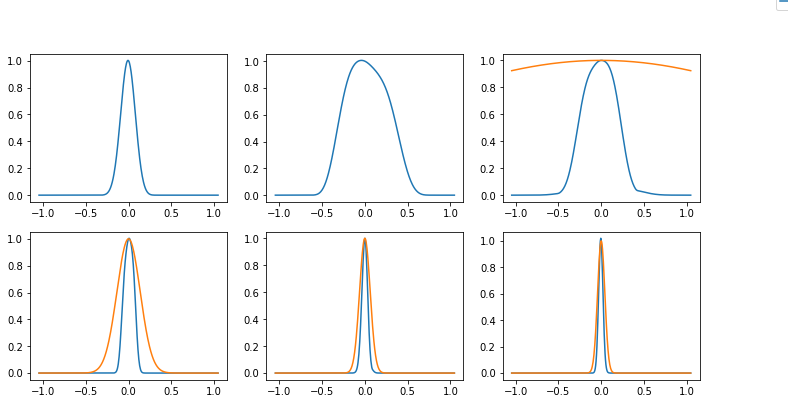

In [84]:
xx = np.linspace(-np.pi/3,np.pi/3,int(2*np.pi/3/0.005)+1)
fig, ax = plt.subplots(ncols=3,nrows=2,figsize=(12,6))
for ii, scan in enumerate(mode_scans):
    #if eigenvalues[ii] < 0: continue
    curr_ax = ax.flatten()[ii]
    curr_ax.plot(xx,np.exp(-scan))
    if eigenvalues[ii] < 0: continue
    #curr_ax.plot(xx,np.exp(-naive_mode_scans[ii]))
    curr_ax.plot(xx,np.exp(-eigenvalues[ii]*xx**2))

# turn off unused subplots
for jj in range(ii+1,6):
    curr_ax = ax.flatten()[jj]
    curr_ax.axis('off')
    
fig.legend(('scan','harmonic'),bbox_to_anchor=(1,1))

## Expression for the dissociation constant in terms of molecular partition function 

The dissociation constant is given by 

$$ K_{\text{d}} = \frac{p_{\text{unbound}}}{p_{\text{bound}}} = \frac{8\pi^2V}{\int_V e^{-\beta E} dr}$$

Denote the integral in the denominator as $Z$. 
And since $\Delta G_{\text{init}}$ is given by $kT \ln K_{\text{d}}$:

$$\Delta G_{\text{init}} = -kT \ln Z + kT \ln 8\pi ^2V $$

N.B. The volume is defined in terms of the reference concentration: $V = \frac{1}{C°} \rightarrow kT \ln 8\pi^2V=kT\ln 8\pi^2 -kT\ln{\text{6.022e-4}}$

In [85]:
multifunc(array_to_vector1(min_dofs)) - total_partition + np.log(8*np.pi**2) - np.log(6.022e-4)

8.3360745709513075